In [1]:
# Basic data manipulation and numerical operations
import numpy as np
import pandas as pd

# Statistical modeling and analysis
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.tools.eval_measures import bic, bic

# Regression tools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import (train_test_split, 
                                   cross_val_score, 
                                   KFold,
                                   cross_validate)
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import (mean_squared_error, 
                           r2_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scientific computing and signal processing
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warning control
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
df = pd.read_csv('../../data-collection/data_interpolated.csv')

# Convert the first column (year) to datetime
# If your years are decimal/float values (e.g., 2020.5), we'll handle that appropriately
df['year'] = pd.to_datetime(df['year'].astype(str).str.split('.').str[0], format='%Y')

# Set year as index for time series analysis
df.set_index('year', inplace=True)

# Sort index to ensure chronological order
df.sort_index(inplace=True)

# Display basic information about the dataset
print("Dataset Overview:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 1913-01-01 to 2024-01-01
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   faculty         53 non-null     float64
 1   NSF_awards      13 non-null     float64
 2   inflation_rate  45 non-null     float64
 3   Fed_Budget      42 non-null     float64
 4   PA_Budget_diff  42 non-null     float64
 5   GDP             75 non-null     float64
 6   CPI_inflation   112 non-null    float64
 7   Labor_BS        33 non-null     float64
 8   Labor_cond      33 non-null     float64
 9   Unemploy_BS     33 non-null     float64
 10  Unemploy        77 non-null     float64
dtypes: float64(11)
memory usage: 10.5 KB
None

First few rows:
            faculty  NSF_awards  inflation_rate  Fed_Budget  PA_Budget_diff  \
year                                                                          
1913-01-01      NaN         NaN             NaN    

In [3]:
def create_aligned_df(df):
    """
    Creates a dataframe with all variables aligned at the same timepoints (no lags).
    Similar interface to create_lagged_df but without temporal offsets.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with 'faculty' and other variables
        
    Returns:
    -----------
    pandas.DataFrame
        Dataframe with all variables aligned at same timepoints
    """
    # Get Y data and its valid range
    y = df['faculty']
    y_start = y.first_valid_index()
    y_end = y.last_valid_index()
    
    # Create new dataframe starting from first valid Y
    new_df = pd.DataFrame({'faculty': y[y_start:y_end]})
    
    # Add each X variable without any lag
    for col in df.columns:
        if col != 'faculty':
            x = df[col]
            # Add to new dataframe without shifting
            new_df[col] = x[y_start:y_end]
    
    return new_df.dropna(how='all')

lagged_df = create_aligned_df(df)

Initial shape: (53, 10)
Shape after dropping all-NaN rows: (53, 10)
Shape after dropping rows with < 5 non-NaN values: (43, 10)
Final shape after filling NaN values: (43, 10)


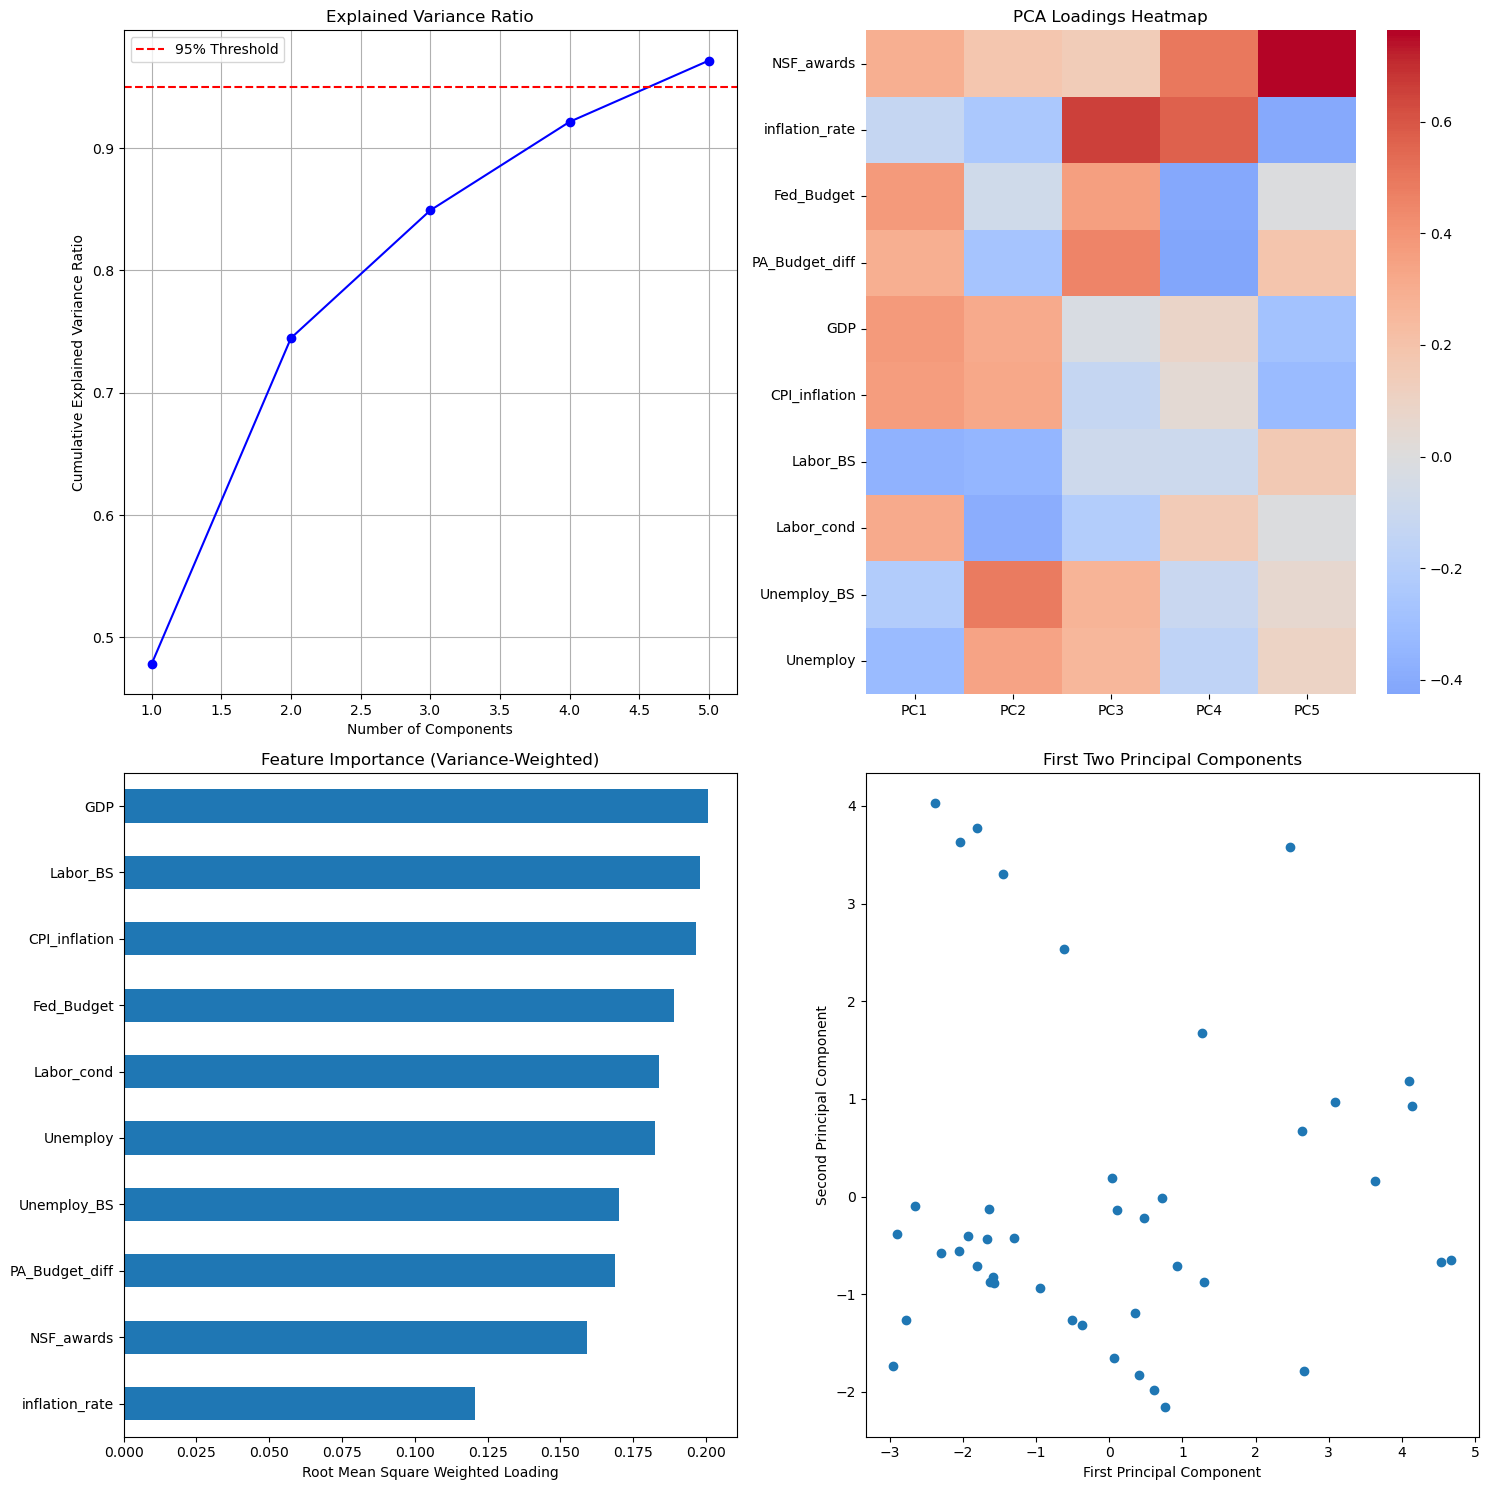


Number of components needed for 95% variance: 5

Dropped features: ['NSF_awards', 'PA_Budget_diff', 'Unemploy', 'Unemploy_BS', 'inflation_rate']

Remaining features: ['faculty', 'GDP', 'Labor_BS', 'CPI_inflation', 'Fed_Budget', 'Labor_cond']


In [4]:
def perform_pca_analysis(lagged_df, variance_threshold=0.95):
   """
   Perform PCA on the X variables in the lagged dataframe.
   Parameters:
       lagged_df: DataFrame with Y and X variables
       variance_threshold: Minimum cumulative variance to explain (default 0.95)
   """
   # Separate Y and X variables
   y = lagged_df['faculty']
   X = lagged_df.drop('faculty', axis=1)
   
   # Print initial shape
   print(f"Initial shape: {X.shape}")
   
   # Remove any rows where ALL X variables are NaN
   X = X.dropna(how='all')
   print(f"Shape after dropping all-NaN rows: {X.shape}")
   
   # Keep only rows where at least N/2 variables have data
   min_non_na = len(X.columns) // 2
   X = X.dropna(thresh=min_non_na)
   print(f"Shape after dropping rows with < {min_non_na} non-NaN values: {X.shape}")
   
   # Fill remaining NaN values using LOWESS for each column
   # Alternative method using forward/backward fill (commented out)
   for col in X.columns:
       non_nan_mask = X[col].notna()
       if non_nan_mask.sum() > 1:  # Need at least 2 points for interpolation
           # Convert datetime index to numeric (days since first observation)
           numeric_index = (X.index - X.index.min()).days
           
           # LOWESS interpolation
           valid_data = X[col][non_nan_mask]
           numeric_valid_index = (valid_data.index - X.index.min()).days
           
           lowess_fit = lowess(valid_data.values, 
                             numeric_valid_index, 
                             frac=0.3)
           
           # Interpolate using the LOWESS fit
        #    X.loc[:, col] = np.interp(numeric_index,
        #                            lowess_fit[:, 0],
        #                            lowess_fit[:, 1])
           
           # Forward/backward fill alternative
           X[col] = X[col].fillna(method='ffill').fillna(method='bfill')
   
   print(f"Final shape after filling NaN values: {X.shape}")
   
   # Rescale X variables
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X)
   
   # Perform initial PCA
   pca = PCA()
   X_pca = pca.fit_transform(X_scaled)
   
   # Determine number of components to reach variance threshold
   cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
   n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
   
   # Refit PCA with selected number of components
   pca = PCA(n_components=n_components)
   X_pca = pca.fit_transform(X_scaled)
   
   # Create DataFrame with PCA results
   pca_df = pd.DataFrame(
       X_pca, 
       columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
       index=X.index
   )
   
   # Calculate explained variance ratio
   explained_variance = pd.DataFrame({
       'Component': [f'PC{i+1}' for i in range(n_components)],
       'Explained_Variance_Ratio': pca.explained_variance_ratio_,
       'Cumulative_Variance_Ratio': np.cumsum(pca.explained_variance_ratio_)
   })
   
   # Get component loadings
   loadings = pd.DataFrame(
       pca.components_.T,
       columns=[f'PC{i+1}' for i in range(n_components)],
       index=X.columns
   )
   
   # Calculate feature importance
   variance_ratios = pca.explained_variance_ratio_
   weighted_loadings = loadings.multiply(variance_ratios, axis=1)
   feature_importance = np.sqrt((weighted_loadings ** 2).sum(axis=1))
   feature_importance = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)
   
   return {
       'pca_results': pca_df,
       'explained_variance': explained_variance,
       'loadings': loadings,
       'original_features': X.columns,
       'feature_importance': feature_importance,
       'pca_model': pca,
       'scaler': scaler,
       'n_components': n_components,
       'X_processed': X  # Added to check the processed data if needed
   }

def plot_pca_results(pca_results):
   """Plot PCA analysis results"""
   fig, axes = plt.subplots(2, 2, figsize=(15, 15))
   
   # Plot explained variance
   axes[0,0].plot(range(1, len(pca_results['explained_variance'])+1),
                  pca_results['explained_variance']['Cumulative_Variance_Ratio'],
                  'bo-')
   axes[0,0].axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
   axes[0,0].set_xlabel('Number of Components')
   axes[0,0].set_ylabel('Cumulative Explained Variance Ratio')
   axes[0,0].grid(True)
   axes[0,0].set_title('Explained Variance Ratio')
   axes[0,0].legend()
   
   # Heatmap of loadings
   sns.heatmap(pca_results['loadings'], ax=axes[0,1], cmap='coolwarm', center=0)
   axes[0,1].set_title('PCA Loadings Heatmap')
   
   # Feature importance bar plot
   feature_importance = pca_results['feature_importance'].sort_values(ascending=True)
   feature_importance.plot(kind='barh', ax=axes[1,0])
   axes[1,0].set_title('Feature Importance (Variance-Weighted)')
   axes[1,0].set_xlabel('Root Mean Square Weighted Loading')
   
   # First two components scatter plot if we have enough components
   if pca_results['pca_results'].shape[1] >= 2:
       axes[1,1].scatter(pca_results['pca_results']['PC1'],
                        pca_results['pca_results']['PC2'])
       axes[1,1].set_xlabel('First Principal Component')
       axes[1,1].set_ylabel('Second Principal Component')
       axes[1,1].set_title('First Two Principal Components')
   
   plt.tight_layout()
   plt.show()

def drop_weak_features(lagged_df, pca_results):
   """
   Drop features not needed to explain 95% of variance
   """
   # Get features sorted by importance
   feature_importance = pca_results['feature_importance']
   
   # Keep only top n_components features
   features_to_keep = feature_importance.nlargest(pca_results['n_components']).index
   features_to_drop = feature_importance.index.difference(features_to_keep)
   
   # Keep faculty column and selected features
   columns_to_keep = ['faculty'] + list(features_to_keep)
   reduced_df = lagged_df[columns_to_keep]
   
   return reduced_df, features_to_drop

pca_results = perform_pca_analysis(lagged_df)
plot_pca_results(pca_results)

# Drop weak features
reduced_df, dropped_features = drop_weak_features(lagged_df, pca_results)

print(f"\nNumber of components needed for 95% variance: {pca_results['n_components']}")
print(f"\nDropped features: {list(dropped_features)}")
print(f"\nRemaining features: {list(reduced_df.columns)}")

In [5]:
def comprehensive_feature_analysis(lagged_df):
    """
    Analyze features using multiple methods without interpolation.
    
    Parameters:
    lagged_df: DataFrame with 'faculty' as target and other columns as features
    
    Returns:
    Dictionary containing analysis results from each method
    """
    y = lagged_df['faculty']
    X = lagged_df.drop('faculty', axis=1)
    
    # Initialize results storage
    analysis_results = {}
    
    # 1. Pairwise Correlation Analysis
    correlations = {}
    p_values = {}
    n_overlapping = {}
    
    for col in X.columns:
        mask = y.notna() & X[col].notna()
        if mask.sum() > 1:
            corr, p_val = pearsonr(y[mask], X[col][mask])
            correlations[col] = corr
            p_values[col] = p_val
            n_overlapping[col] = mask.sum()
    
    correlation_results = pd.DataFrame({
        'Correlation': correlations,
        'P_Value': p_values,
        'Overlapping_Points': n_overlapping
    }).sort_values('Correlation', key=abs, ascending=False)
    
    analysis_results['correlation_analysis'] = correlation_results
    
    # 2. Improved Lasso Feature Analysis
    feature_importance_lasso = {}
    n_folds = 5
    
    # First, identify common valid samples across all features
    common_mask = y.notna()
    for col in X.columns:
        common_mask = common_mask & X[col].notna()
    
    if common_mask.sum() > n_folds:  # Ensure enough samples for CV
        X_valid = X[common_mask]
        y_valid = y[common_mask]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_valid)
        X_scaled = pd.DataFrame(X_scaled, columns=X_valid.columns)
        
        # Perform LASSO with cross-validation
        lasso = LassoCV(cv=min(n_folds, common_mask.sum()), 
                       random_state=42, 
                       max_iter=2000,
                       selection='random')
        
        # Fit LASSO multiple times with different random seeds for stability
        n_iterations = 10
        coef_matrix = np.zeros((n_iterations, len(X.columns)))
        
        for i in range(n_iterations):
            lasso.random_state = 42 + i
            lasso.fit(X_scaled, y_valid)
            coef_matrix[i, :] = np.abs(lasso.coef_)
        
        # Calculate feature importance as the average absolute coefficient value
        mean_coef = np.mean(coef_matrix, axis=0)
        std_coef = np.std(coef_matrix, axis=0)
        
        # Store results with confidence measure
        for idx, col in enumerate(X.columns):
            feature_importance_lasso[col] = mean_coef[idx]
    else:
        # Fallback if not enough common samples
        for col in X.columns:
            feature_importance_lasso[col] = 0
    
    analysis_results['lasso_analysis'] = pd.Series(feature_importance_lasso).sort_values(ascending=False)
    
    # 3. Mutual Information Analysis
    mi_scores = {}
    
    for col in X.columns:
        mask = y.notna() & X[col].notna()
        if mask.sum() > 1:
            X_feature = X[col][mask].values.reshape(-1, 1)
            y_aligned = y[mask]
            mi_scores[col] = mutual_info_regression(X_feature, y_aligned, random_state=42)[0]
    
    analysis_results['mutual_information'] = pd.Series(mi_scores).sort_values(ascending=False)
    
    # Combined Results
    combined_scores = pd.DataFrame({
        'Correlation': correlation_results['Correlation'],
        'P_Value': correlation_results['P_Value'],
        'Overlapping_Points': correlation_results['Overlapping_Points'],
        'Lasso_Importance': analysis_results['lasso_analysis'],
        'MI_Score': analysis_results['mutual_information']
    })
    
    analysis_results['combined_analysis'] = combined_scores
    
    top_n = 5

    # Print summary information
    print("Feature Analysis Summary:")
    print(f"Total features analyzed: {len(X.columns)}")
    print(f"\nTop {top_n} features by different metrics:")
    print("\nBy absolute correlation:")
    print(combined_scores.sort_values('Correlation', key=abs, ascending=False).head(top_n)[['Correlation', 'P_Value', 'Overlapping_Points']])
    print("\nBy Lasso importance:")
    print(combined_scores.sort_values('Lasso_Importance', ascending=False).head(top_n)[['Lasso_Importance', 'Overlapping_Points']])
    print("\nBy Mutual Information:")
    print(combined_scores.sort_values('MI_Score', ascending=False).head(5)[['MI_Score', 'Overlapping_Points']])
    
    return analysis_results

results = comprehensive_feature_analysis(lagged_df)
full_analysis = results['combined_analysis']

Feature Analysis Summary:
Total features analyzed: 10

Top 5 features by different metrics:

By absolute correlation:
                Correlation       P_Value  Overlapping_Points
CPI_inflation      0.975154  4.713036e-35                  53
GDP                0.965559  1.737339e-31                  53
Labor_BS          -0.913752  7.230535e-13                  31
inflation_rate    -0.463263  1.757418e-03                  43
Fed_Budget         0.437721  3.743710e-03                  42

By Lasso importance:
                Lasso_Importance  Overlapping_Points
Unemploy_BS         16222.013158                  31
Labor_BS             8261.570584                  31
inflation_rate       5731.334781                  43
Fed_Budget           2880.094746                  42
GDP                  2604.855317                  53

By Mutual Information:
                MI_Score  Overlapping_Points
GDP             1.971053                  53
CPI_inflation   1.951164                  53
Labor_BS   

These results are good, since they help us confirm the PCA that required some degree of filling in values. These methods do not.


Regression Analysis Results:

Degree 1:
Mean CV R² Score: 0.9055 ± 0.0308
Mean BIC Score: 878.91 ± 11.92

Degree 2:
Mean CV R² Score: 0.1855 ± 0.4607
Mean BIC Score: 843.34 ± 8.29

Degree 3:
Mean CV R² Score: -63.9275 ± 49.4672
Mean BIC Score: -995.85 ± 24.52

Degree 4:
Mean CV R² Score: -51.0277 ± 68.4869
Mean BIC Score: -967.60 ± 16.71

Degree 5:
Mean CV R² Score: -324.4016 ± 286.3160
Mean BIC Score: -867.65 ± 17.69

Best model (degree 3) summary:
                            OLS Regression Results                            
Dep. Variable:                faculty   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 01 Dec 2024   Prob (F-statistic):                nan
Time:                        08:58:29   Log-Likelihood:                 628.04
No. Observations:                  43   AIC:                           

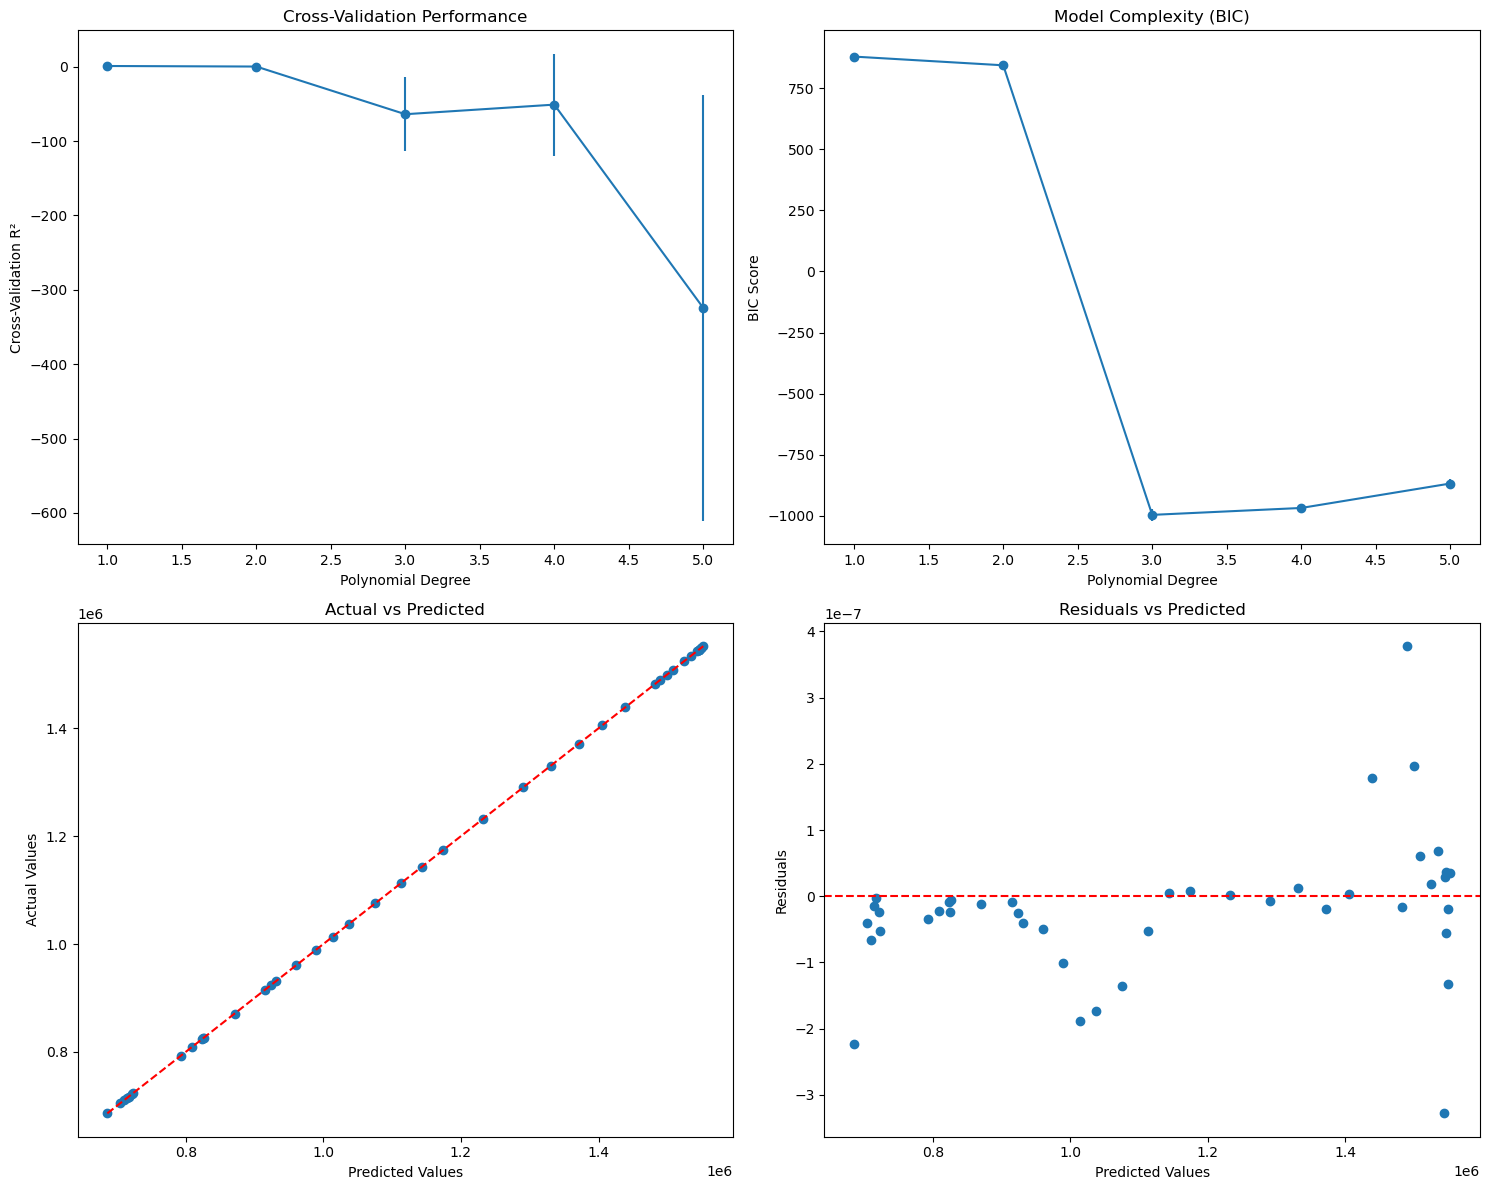

In [6]:
def perform_ols_regression(pca_results, target_series, max_degree=5, n_splits=5):
    """Modified to use BIC instead of AIC"""
    X = pca_results['pca_results']
    y = target_series
    
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]
    
    results = {}
    
    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X)
        
        model = sm.OLS(y, sm.add_constant(X_poly))
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = []
        bic_scores = []
        
        for train_idx, test_idx in kf.split(X_poly):
            X_train, X_test = X_poly[train_idx], X_poly[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model_fold = sm.OLS(y_train, sm.add_constant(X_train))
            results_fold = model_fold.fit()
            
            y_pred = results_fold.predict(sm.add_constant(X_test))
            cv_scores.append(r2_score(y_test, y_pred))
            bic_scores.append(results_fold.bic)
        
        final_results = model.fit()
        
        results[degree] = {
            'model': final_results,
            'cv_r2_mean': np.mean(cv_scores),
            'cv_r2_std': np.std(cv_scores),
            'bic_mean': np.mean(bic_scores),
            'bic_std': np.std(bic_scores),
            'summary': final_results.summary(),
            'feature_names': poly.get_feature_names_out(X.columns)
        }
    
    best_degree = min(results.keys(), key=lambda k: results[k]['bic_mean'])
    
    print("\nRegression Analysis Results:")
    print("===========================")
    for degree in results:
        print(f"\nDegree {degree}:")
        print(f"Mean CV R² Score: {results[degree]['cv_r2_mean']:.4f} ± {results[degree]['cv_r2_std']:.4f}")
        print(f"Mean BIC Score: {results[degree]['bic_mean']:.2f} ± {results[degree]['bic_std']:.2f}")
    
    print(f"\nBest model (degree {best_degree}) summary:")
    print(results[best_degree]['summary'])
    
    return results, best_degree

def plot_regression_results(results, best_degree):
    """Plot regression analysis results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot CV R² scores
    degrees = list(results.keys())
    cv_scores = [results[d]['cv_r2_mean'] for d in degrees]
    cv_errors = [results[d]['cv_r2_std'] for d in degrees]
    
    axes[0,0].errorbar(degrees, cv_scores, yerr=cv_errors, fmt='o-')
    axes[0,0].set_xlabel('Polynomial Degree')
    axes[0,0].set_ylabel('Cross-Validation R²')
    axes[0,0].set_title('Cross-Validation Performance')
    
    # Plot BIC scores
    bic_scores = [results[d]['bic_mean'] for d in degrees]
    bic_errors = [results[d]['bic_std'] for d in degrees]
    
    axes[0,1].errorbar(degrees, bic_scores, yerr=bic_errors, fmt='o-')
    axes[0,1].set_xlabel('Polynomial Degree')
    axes[0,1].set_ylabel('BIC Score')
    axes[0,1].set_title('Model Complexity (BIC)')
    
    # Get best model predictions and residuals
    best_model = results[best_degree]['model']
    y_pred = best_model.fittedvalues
    residuals = best_model.resid
    
    # Actual vs Predicted plot
    axes[1,0].scatter(y_pred, best_model.model.endog)
    axes[1,0].plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'r--')
    axes[1,0].set_xlabel('Predicted Values')
    axes[1,0].set_ylabel('Actual Values')
    axes[1,0].set_title('Actual vs Predicted')
    
    # Residuals plot
    axes[1,1].scatter(y_pred, residuals)
    axes[1,1].axhline(y=0, color='r', linestyle='--')
    axes[1,1].set_xlabel('Predicted Values')
    axes[1,1].set_ylabel('Residuals')
    axes[1,1].set_title('Residuals vs Predicted')
    
    plt.tight_layout()
    plt.show()

regression_results, best_degree = perform_ols_regression(pca_results, lagged_df['faculty'])
plot_regression_results(regression_results, best_degree)


ARIMA Analysis Results:
Best ARIMA(3, 3, 5)

Metrics:
MSE: 1104223557.2244
RMSE: 33229.8594
MAPE: 1.94%
BIC: 1055.47

Future Predictions (2023-2025):
2023: 1542340.90 (95% CI: [1512705.91, 1571975.88])
2024: 1539084.39 (95% CI: [1478452.20, 1599716.58])
2025: 1536789.50 (95% CI: [1440206.38, 1633372.63])


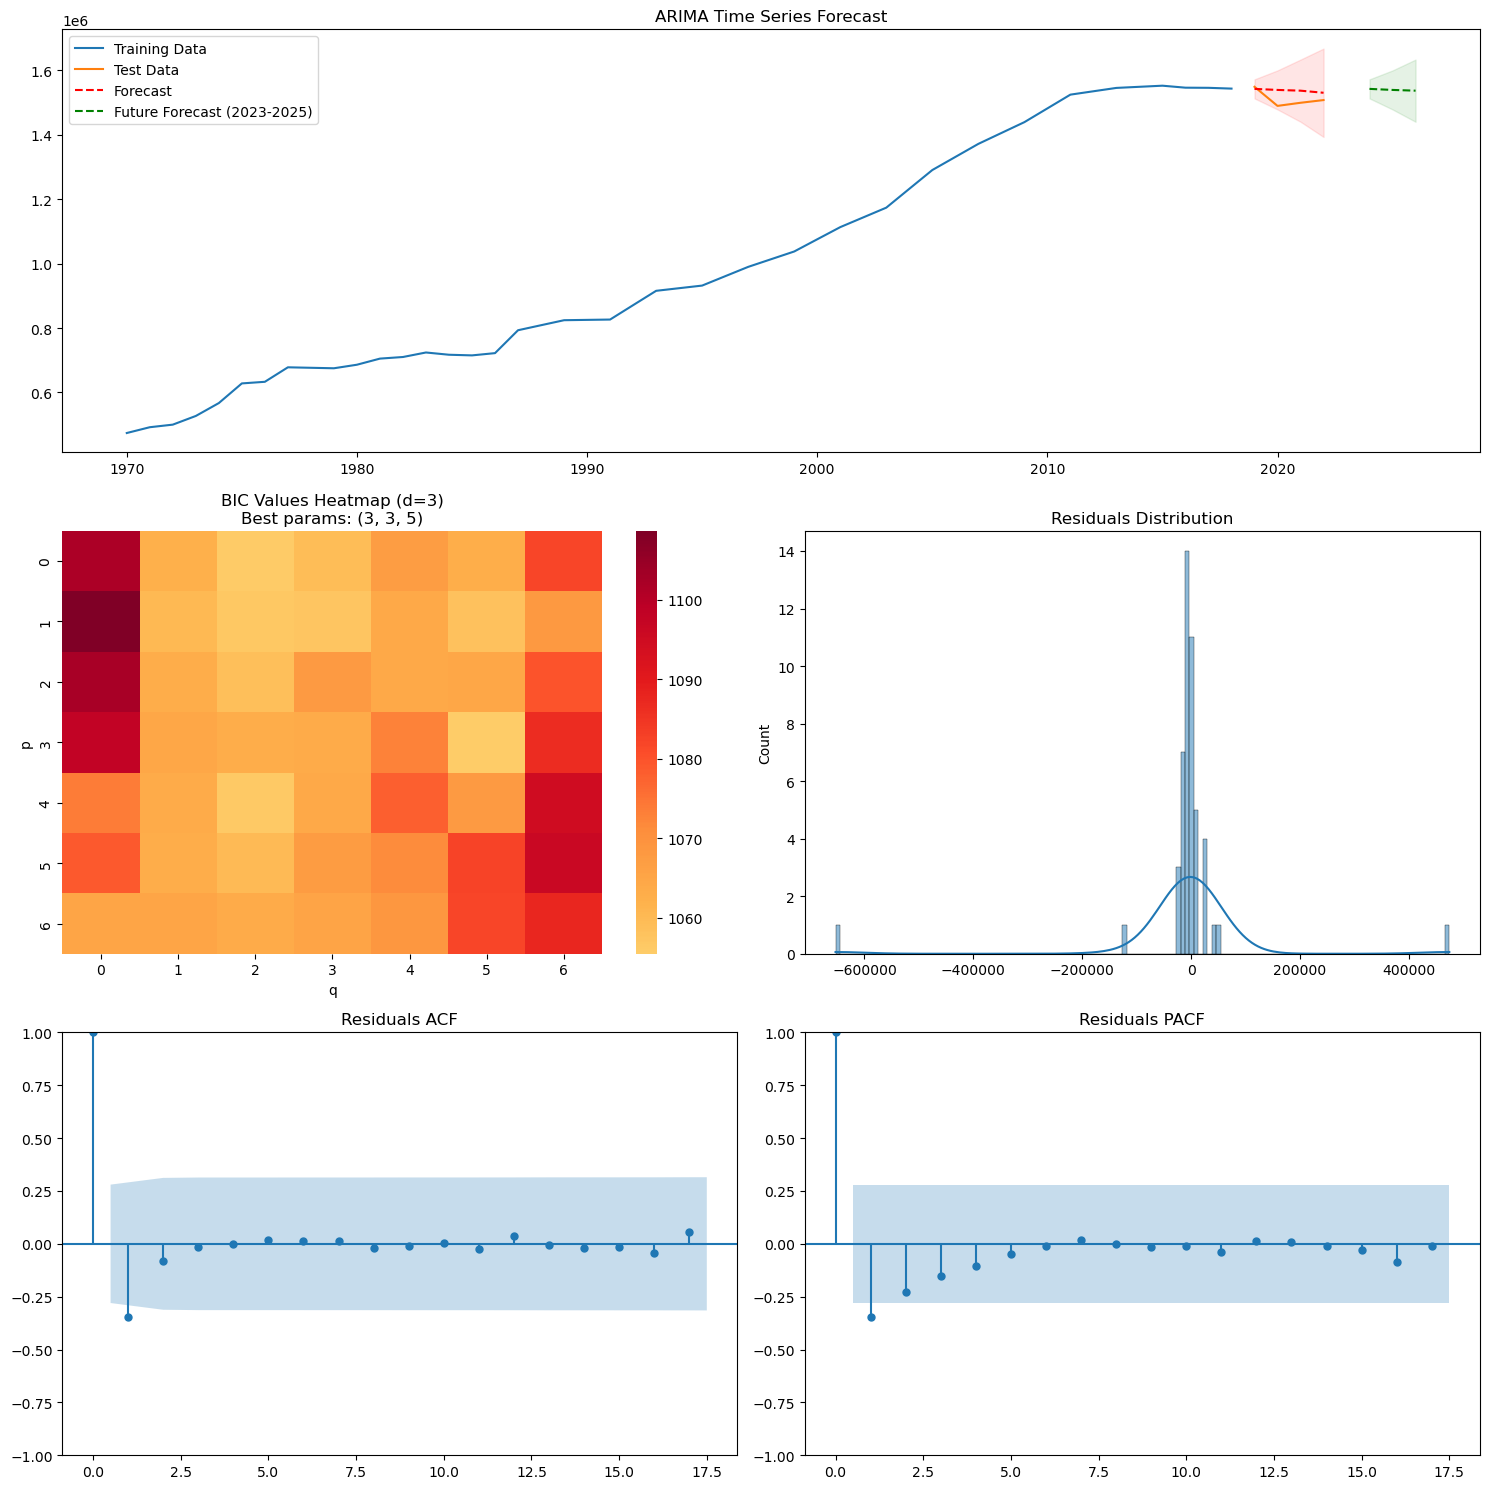


ARIMA Analysis Results:
Best ARIMA(3, 3, 5)

Metrics:
MSE: 1104223557.2244
RMSE: 33229.8594
MAPE: 1.94%
BIC: 1055.47

Future Predictions (2023-2025):
2023: 1542340.90 (95% CI: [1512705.91, 1571975.88])
2024: 1539084.39 (95% CI: [1478452.20, 1599716.58])
2025: 1536789.50 (95% CI: [1440206.38, 1633372.63])


In [7]:
def find_optimal_arima_params(series, max_p=3, max_d=2, max_q=3):
    """Modified to use BIC instead of AIC"""
    best_bic = float('inf')
    best_params = None
    best_model = None
    
    bic_values = {}
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                if p == 0 and d == 0 and q == 0:
                    continue
                    
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    bic = results.bic
                    
                    bic_values[(p, d, q)] = bic
                    
                    if bic < best_bic:
                        best_bic = bic
                        best_params = (p, d, q)
                        best_model = results
                        
                except Exception as e:
                    continue
    
    return best_model, best_params, bic_values

def perform_arima_analysis(series, max_p=3, max_d=2, max_q=3, test_size=5):
    """
    Perform comprehensive ARIMA analysis including cross-validation.
    
    Parameters:
        series: Time series to model
        max_p, max_d, max_q: Maximum orders for ARIMA parameters
        test_size: Number of periods to hold out for testing
    """
    # Convert index to datetime if it's not already
    if not isinstance(series.index, pd.DatetimeIndex):
        series.index = pd.to_datetime(series.index)
    
    # Split data into train and test sets
    train = series[:-test_size]
    test = series[-test_size:]
    
    # Find optimal parameters using training data
    best_model, best_params, bic_values = find_optimal_arima_params(
        train, max_p, max_d, max_q
    )
    
    # Make forecasts
    forecast = best_model.forecast(steps=test_size)
    forecast_ci = best_model.get_forecast(steps=test_size).conf_int()
    
    # Calculate error metrics
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    
    # Make future predictions (2023-2025)
    future_dates = pd.date_range(
        start=series.index[-1] + pd.DateOffset(years=1),
        periods=3,
        freq='Y'
    )
    future_forecast = best_model.forecast(steps=3)
    future_ci = best_model.get_forecast(steps=3).conf_int()
    
    # Store results
    results = {
        'model': best_model,
        'best_params': best_params,
        'bic_values': bic_values,
        'train': train,
        'test': test,
        'forecast': forecast,
        'forecast_ci': forecast_ci,
        'future_forecast': future_forecast,
        'future_dates': future_dates,
        'future_ci': future_ci,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'bic': best_model.bic
        }
    }
    
    return results

def plot_arima_results(results):
    """Plot comprehensive ARIMA analysis results"""
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(3, 2)
    
    # Plot 1: Time series with forecasts
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot original data
    ax1.plot(results['train'].index, results['train'], label='Training Data')
    ax1.plot(results['test'].index, results['test'], label='Test Data')
    
    # Plot forecasts
    ax1.plot(results['test'].index, results['forecast'], 
             'r--', label='Forecast')
    ax1.fill_between(results['test'].index,
                     results['forecast_ci'].iloc[:, 0],
                     results['forecast_ci'].iloc[:, 1],
                     color='r', alpha=0.1)
    
    # Plot future predictions
    ax1.plot(results['future_dates'], results['future_forecast'],
             'g--', label='Future Forecast (2023-2025)')
    ax1.fill_between(results['future_dates'],
                     results['future_ci'].iloc[:, 0],
                     results['future_ci'].iloc[:, 1],
                     color='g', alpha=0.1)
    
    ax1.set_title('ARIMA Time Series Forecast')
    ax1.legend()
    
    # Plot 2: BIC values heatmap for different p,d,q combinations
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Create properly structured DataFrame for BIC values
    max_p = max(p for p, _, _ in results['bic_values'].keys())
    max_d = max(d for _, d, _ in results['bic_values'].keys())
    max_q = max(q for _, _, q in results['bic_values'].keys())
    
    bic_matrix = np.full((max_p + 1, max_q + 1), np.nan)
    for (p, d, q), bic in results['bic_values'].items():
        if d == results['best_params'][1]:  # Plot for optimal d value
            bic_matrix[p, q] = bic
    
    # Create DataFrame with proper indices
    bic_df = pd.DataFrame(
        bic_matrix,
        index=range(max_p + 1),
        columns=range(max_q + 1)
    )
    
    sns.heatmap(bic_df, 
                ax=ax2, 
                cmap='YlOrRd',
                center=np.nanmean(bic_matrix),
                mask=np.isnan(bic_matrix))
    ax2.set_title(f'BIC Values Heatmap (d={results["best_params"][1]})\nBest params: {results["best_params"]}')
    ax2.set_xlabel('q')
    ax2.set_ylabel('p')
    
    # Plot 3: Residuals analysis
    ax3 = fig.add_subplot(gs[1, 1])
    residuals = results['model'].resid
    sns.histplot(residuals, kde=True, ax=ax3)
    ax3.set_title('Residuals Distribution')
    
    # Plot 4: ACF of residuals
    ax4 = fig.add_subplot(gs[2, 0])
    sm.graphics.tsa.plot_acf(residuals, ax=ax4)
    ax4.set_title('Residuals ACF')
    
    # Plot 5: PACF of residuals
    ax5 = fig.add_subplot(gs[2, 1])
    sm.graphics.tsa.plot_pacf(residuals, ax=ax5)
    ax5.set_title('Residuals PACF')
    
    plt.tight_layout()
    
    # Print metrics
    print("\nARIMA Analysis Results:")
    print("====================")
    print(f"Best ARIMA{results['best_params']}")
    print(f"\nMetrics:")
    print(f"MSE: {results['metrics']['mse']:.4f}")
    print(f"RMSE: {results['metrics']['rmse']:.4f}")
    print(f"MAPE: {results['metrics']['mape']:.2f}%")
    print(f"BIC: {results['metrics']['bic']:.2f}")
    
    print("\nFuture Predictions (2023-2025):")
    for date, pred, (lower, upper) in zip(
        results['future_dates'],
        results['future_forecast'],
        results['future_ci'].values
    ):
        print(f"{date.year}: {pred:.2f} (95% CI: [{lower:.2f}, {upper:.2f}])")
    
    plt.show()
    
    # Print metrics
    print("\nARIMA Analysis Results:")
    print("====================")
    print(f"Best ARIMA{results['best_params']}")
    print(f"\nMetrics:")
    print(f"MSE: {results['metrics']['mse']:.4f}")
    print(f"RMSE: {results['metrics']['rmse']:.4f}")
    print(f"MAPE: {results['metrics']['mape']:.2f}%")
    print(f"BIC: {results['metrics']['bic']:.2f}")
    
    print("\nFuture Predictions (2023-2025):")
    for date, pred, (lower, upper) in zip(
        results['future_dates'],
        results['future_forecast'],
        results['future_ci'].values
    ):
        print(f"{date.year}: {pred:.2f} (95% CI: [{lower:.2f}, {upper:.2f}])")
    
    plt.show()


arima_results = perform_arima_analysis(lagged_df['faculty'], 6, 3, 6, test_size=4)
plot_arima_results(arima_results)


LOWESS Analysis Results:
Best fraction: 0.200

Future Predictions (2023-2025):
2023: 1490590.58 (95% CI: [-455065.64, 2475198.23])
2024: 1481455.69 (95% CI: [-1437263.12, 3422153.22])
2025: 1472320.79 (95% CI: [-2418150.27, 4379026.72])


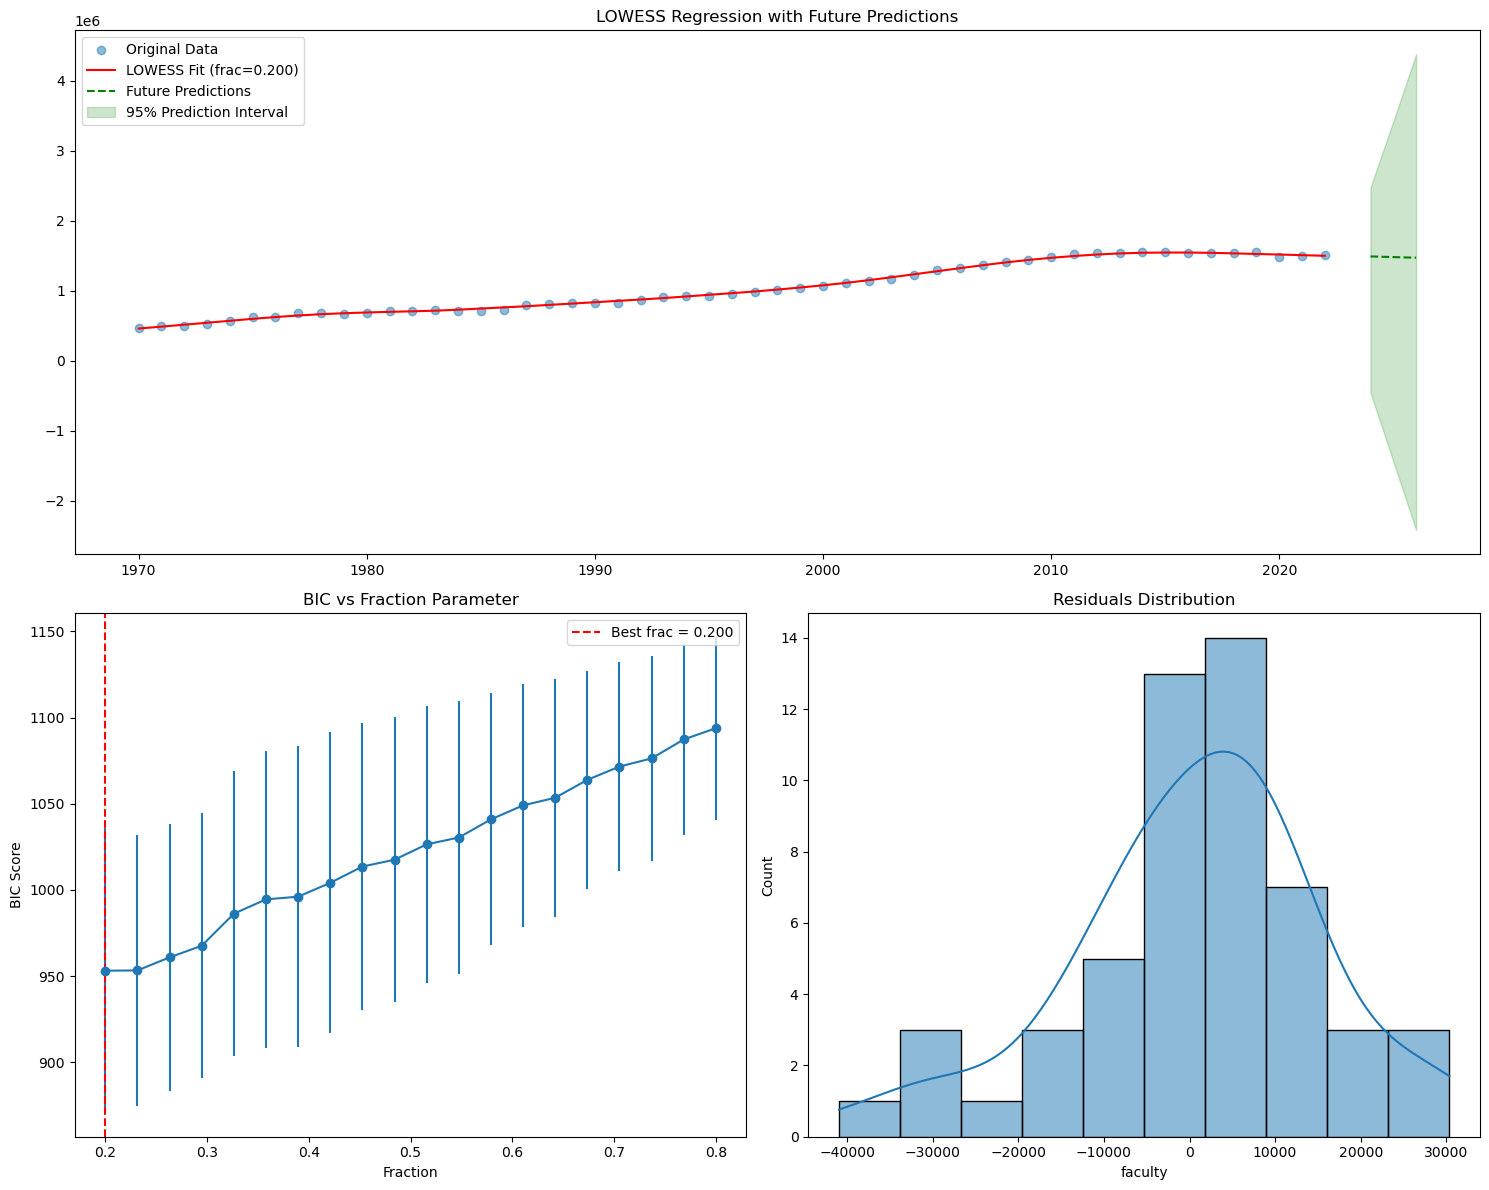

In [8]:
def perform_lowess_analysis(y, frac_range=None, k_fold=5):
    """Modified to use BIC instead of AIC"""
    x = np.arange(len(y))
    
    if frac_range is None:
        frac_range = np.linspace(0.2, 0.8, 20)
    
    results = {}
    
    kf = KFold(n_splits=k_fold, shuffle=False)
    
    for frac in frac_range:
        cv_scores = []
        bic_scores = []
        
        for train_idx, test_idx in kf.split(x):
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            lowess_fit = lowess(y_train, x_train, frac=frac, return_sorted=False)
            
            f_interpolate = interp1d(x_train, lowess_fit, bounds_error=False, fill_value="extrapolate")
            y_pred_test = f_interpolate(x_test)
            
            mse = mean_squared_error(y_test, y_pred_test)
            cv_scores.append(mse)
            
            n = len(y_train)
            effective_params = int(n * frac)
            bic = n * np.log(mse) + effective_params * np.log(n)  # Changed to BIC formula
            bic_scores.append(bic)
        
        results[frac] = {
            'cv_mse_mean': np.mean(cv_scores),
            'cv_mse_std': np.std(cv_scores),
            'bic_mean': np.mean(bic_scores),
            'bic_std': np.std(bic_scores)
        }
    
    best_frac = min(results.keys(), key=lambda k: results[k]['bic_mean'])
    
    final_fit = lowess(y, x, frac=best_frac, return_sorted=False)
    
    # Make future predictions (2023-2025)
    future_x = np.arange(len(y), len(y) + 3)
    f_future = interp1d(x, final_fit, bounds_error=False, fill_value="extrapolate")
    future_predictions = f_future(future_x)
    
    # Calculate confidence intervals using bootstrap
    n_bootstrap = 1000
    bootstrap_predictions = np.zeros((n_bootstrap, len(future_x)))
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        idx = np.random.randint(0, len(y), size=len(y))
        y_boot = y.iloc[idx]
        x_boot = x[idx]
        
        # Fit LOWESS to bootstrap sample
        fit_boot = lowess(y_boot, x_boot, frac=best_frac, return_sorted=False)
        f_boot = interp1d(x, fit_boot, bounds_error=False, fill_value="extrapolate")
        bootstrap_predictions[i] = f_boot(future_x)
    
    # Calculate confidence intervals
    future_ci = np.percentile(bootstrap_predictions, [2.5, 97.5], axis=0)
    
    return {
        'best_frac': best_frac,
        'results': results,
        'fitted_values': final_fit,
        'future_predictions': future_predictions,
        'future_ci': future_ci,
        'x': x,
        'future_x': future_x
    }

def plot_lowess_results(y, analysis_results):
    """Plot LOWESS analysis results"""
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2)
    
    # Plot 1: Original data, fit, and predictions
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot original data
    ax1.scatter(y.index, y, alpha=0.5, label='Original Data')
    
    # Plot fitted values
    ax1.plot(y.index, analysis_results['fitted_values'], 'r-', 
             label=f'LOWESS Fit (frac={analysis_results["best_frac"]:.3f})')
    
    # Plot future predictions
    future_dates = pd.date_range(
        start=y.index[-1] + pd.DateOffset(years=1),
        periods=3,
        freq='Y'
    )
    
    ax1.plot(future_dates, analysis_results['future_predictions'], 
             'g--', label='Future Predictions')
    
    # Add confidence intervals for future predictions
    ax1.fill_between(
        future_dates,
        analysis_results['future_ci'][0],
        analysis_results['future_ci'][1],
        color='g', alpha=0.2,
        label='95% Prediction Interval'
    )
    
    ax1.set_title('LOWESS Regression with Future Predictions')
    ax1.legend()
    
    # Plot 2: BIC scores
    ax2 = fig.add_subplot(gs[1, 0])
    fracs = list(analysis_results['results'].keys())
    bic_means = [analysis_results['results'][f]['bic_mean'] for f in fracs]
    bic_stds = [analysis_results['results'][f]['bic_std'] for f in fracs]
    
    ax2.errorbar(fracs, bic_means, yerr=bic_stds, fmt='o-')
    ax2.axvline(x=analysis_results['best_frac'], color='r', linestyle='--',
                label=f'Best frac = {analysis_results["best_frac"]:.3f}')
    ax2.set_xlabel('Fraction')
    ax2.set_ylabel('BIC Score')
    ax2.set_title('BIC vs Fraction Parameter')
    ax2.legend()
    
    # Plot 3: Residuals
    ax3 = fig.add_subplot(gs[1, 1])
    residuals = y - analysis_results['fitted_values']
    sns.histplot(residuals, kde=True, ax=ax3)
    ax3.set_title('Residuals Distribution')
    
    plt.tight_layout()
    
    # Print results
    print("\nLOWESS Analysis Results:")
    print("=====================")
    print(f"Best fraction: {analysis_results['best_frac']:.3f}")
    print("\nFuture Predictions (2023-2025):")
    for date, pred, (lower, upper) in zip(
        future_dates,
        analysis_results['future_predictions'],
        analysis_results['future_ci'].T
    ):
        print(f"{date.year}: {pred:.2f} (95% CI: [{lower:.2f}, {upper:.2f}])")
    
    plt.show()

lowess_analysis = perform_lowess_analysis(lagged_df['faculty'])
plot_lowess_results(lagged_df['faculty'], lowess_analysis)


Gaussian Process Regression Results:
Best parameters:
Length scale: 1.000e-02
Noise level: 1.000e-03

Future Predictions (2023-2025):
2023: 549.64 (95% CI: [-70.17, 1169.45])
2024: 549.64 (95% CI: [-70.17, 1169.45])
2025: 549.64 (95% CI: [-70.17, 1169.45])


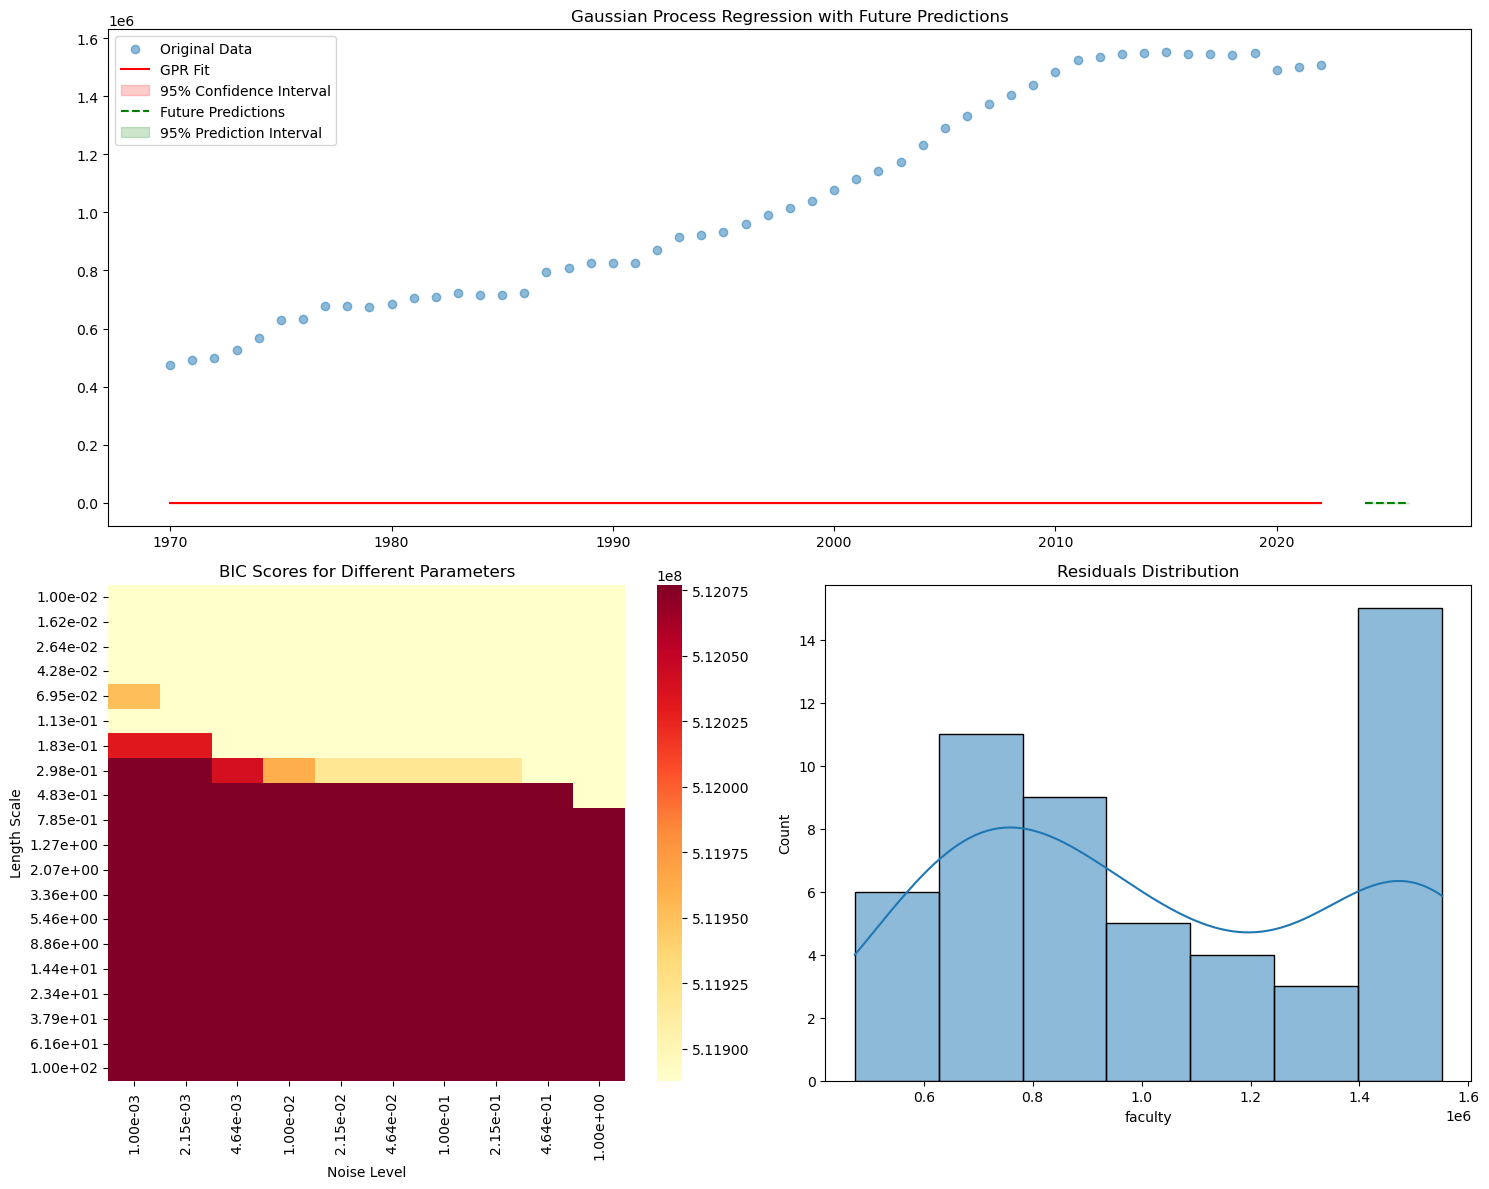

In [ ]:
def perform_gpr_analysis(y, kernel_type='RBF', k_fold=5):
    """Modified to use BIC instead of AIC"""
    x = np.arange(len(y)).reshape(-1, 1)
    x_scaled = (x - x.min()) / (x.max() - x.min())
    
    if kernel_type == 'RBF':
        length_scales = np.logspace(-2, 2, 20)
        noise_levels = np.logspace(-3, 0, 10)
        
        best_bic = float('inf')
        best_params = None
        results = {}
        
        for length_scale in length_scales:
            for noise_level in noise_levels:
                kernel = RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
                
                cv_scores = []
                bic_scores = []
                
                kf = KFold(n_splits=k_fold, shuffle=False)
                
                for train_idx, test_idx in kf.split(x_scaled):
                    X_train, X_test = x_scaled[train_idx], x_scaled[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                    
                    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
                    gpr.fit(X_train, y_train)
                    
                    y_pred, y_std = gpr.predict(X_test, return_std=True)
                    
                    mse = mean_squared_error(y_test, y_pred)
                    cv_scores.append(mse)
                    
                    n = len(y_train)
                    bic = -2 * gpr.log_marginal_likelihood() + 2 * np.log(n)  # Changed to BIC formula
                    bic_scores.append(bic)
                
                results[(length_scale, noise_level)] = {
                    'cv_mse_mean': np.mean(cv_scores),
                    'cv_mse_std': np.std(cv_scores),
                    'bic_mean': np.mean(bic_scores),
                    'bic_std': np.std(bic_scores)
                }
                
                if np.mean(bic_scores) < best_bic:
                    best_bic = np.mean(bic_scores)
                    best_params = (length_scale, noise_level)
    
    best_kernel = RBF(length_scale=best_params[0]) + WhiteKernel(noise_level=best_params[1])
    final_gpr = GaussianProcessRegressor(kernel=best_kernel, random_state=420)
    final_gpr.fit(x_scaled, y)
    
    # Get fitted values and confidence intervals
    y_pred, y_std = final_gpr.predict(x_scaled, return_std=True)
    
    # Make future predictions (2023-2025)
    future_x = np.arange(len(y), len(y) + 3).reshape(-1, 1)
    future_x_scaled = (future_x - x.min()) / (x.max() - x.min())
    future_pred, future_std = final_gpr.predict(future_x_scaled, return_std=True)
    
    return {
        'best_params': best_params,
        'results': results,
        'fitted_values': y_pred,
        'fitted_std': y_std,
        'future_predictions': future_pred,
        'future_std': future_std,
        'model': final_gpr,
        'x_scaled': x_scaled,
        'future_x_scaled': future_x_scaled
    }

def plot_gpr_results(y, analysis_results):
    """Plot GPR analysis results"""
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2)
    
    # Plot 1: Original data, fit, and predictions
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot original data and fitted values
    ax1.scatter(y.index, y, alpha=0.5, label='Original Data')
    ax1.plot(y.index, analysis_results['fitted_values'], 'r-', label='GPR Fit')
    
    # Add confidence intervals for fitted values
    ax1.fill_between(
        y.index,
        analysis_results['fitted_values'] - 1.96 * analysis_results['fitted_std'],
        analysis_results['fitted_values'] + 1.96 * analysis_results['fitted_std'],
        color='r', alpha=0.2,
        label='95% Confidence Interval'
    )
    
    # Plot future predictions
    future_dates = pd.date_range(
        start=y.index[-1] + pd.DateOffset(years=1),
        periods=3,
        freq='Y'
    )
    
    ax1.plot(future_dates, analysis_results['future_predictions'], 
             'g--', label='Future Predictions')
    
    # Add confidence intervals for future predictions
    ax1.fill_between(
        future_dates,
        analysis_results['future_predictions'] - 1.96 * analysis_results['future_std'],
        analysis_results['future_predictions'] + 1.96 * analysis_results['future_std'],
        color='g', alpha=0.2,
        label='95% Prediction Interval'
    )
    
    ax1.set_title('Gaussian Process Regression with Future Predictions')
    ax1.legend()
    
    # Plot 2: Parameter heatmap
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Create heatmap of BIC scores
    length_scales = sorted(set(ls for ls, _ in analysis_results['results'].keys()))
    noise_levels = sorted(set(nl for _, nl in analysis_results['results'].keys()))
    
    bic_matrix = np.zeros((len(length_scales), len(noise_levels)))
    for i, ls in enumerate(length_scales):
        for j, nl in enumerate(noise_levels):
            if (ls, nl) in analysis_results['results']:
                bic_matrix[i, j] = analysis_results['results'][(ls, nl)]['bic_mean']
    
    sns.heatmap(bic_matrix, 
                xticklabels=[f'{nl:.2e}' for nl in noise_levels],
                yticklabels=[f'{ls:.2e}' for ls in length_scales],
                ax=ax2, cmap='YlOrRd')
    ax2.set_xlabel('Noise Level')
    ax2.set_ylabel('Length Scale')
    ax2.set_title('BIC Scores for Different Parameters')
    
    # Plot 3: Residuals
    ax3 = fig.add_subplot(gs[1, 1])
    residuals = y - analysis_results['fitted_values']
    sns.histplot(residuals, kde=True, ax=ax3)
    ax3.set_title('Residuals Distribution')
    
    plt.tight_layout()
    
    # Print results
    print("\nGaussian Process Regression Results:")
    print("================================")
    print(f"Best parameters:")
    print(f"Length scale: {analysis_results['best_params'][0]:.3e}")
    print(f"Noise level: {analysis_results['best_params'][1]:.3e}")
    
    print("\nFuture Predictions (2023-2025):")
    for date, pred, std in zip(
        future_dates,
        analysis_results['future_predictions'],
        analysis_results['future_std']
    ):
        lower = pred - 1.96 * std
        upper = pred + 1.96 * std
        print(f"{date.year}: {pred:.2f} (95% CI: [{lower:.2f}, {upper:.2f}])")
    
    plt.show()

gpr_analysis = perform_gpr_analysis(lagged_df['faculty'])
plot_gpr_results(lagged_df['faculty'], gpr_analysis)


Gaussian Process Regression Results:
Best parameters:
Length scale: 7.848e+00
Noise level: 1.000e+00

Future Predictions (2023-2025):
2023: 1485044.81 (95% CI: [1441448.91, 1528640.72])
2024: 1475615.41 (95% CI: [1416507.08, 1534723.75])
2025: 1466487.38 (95% CI: [1385315.99, 1547658.77])


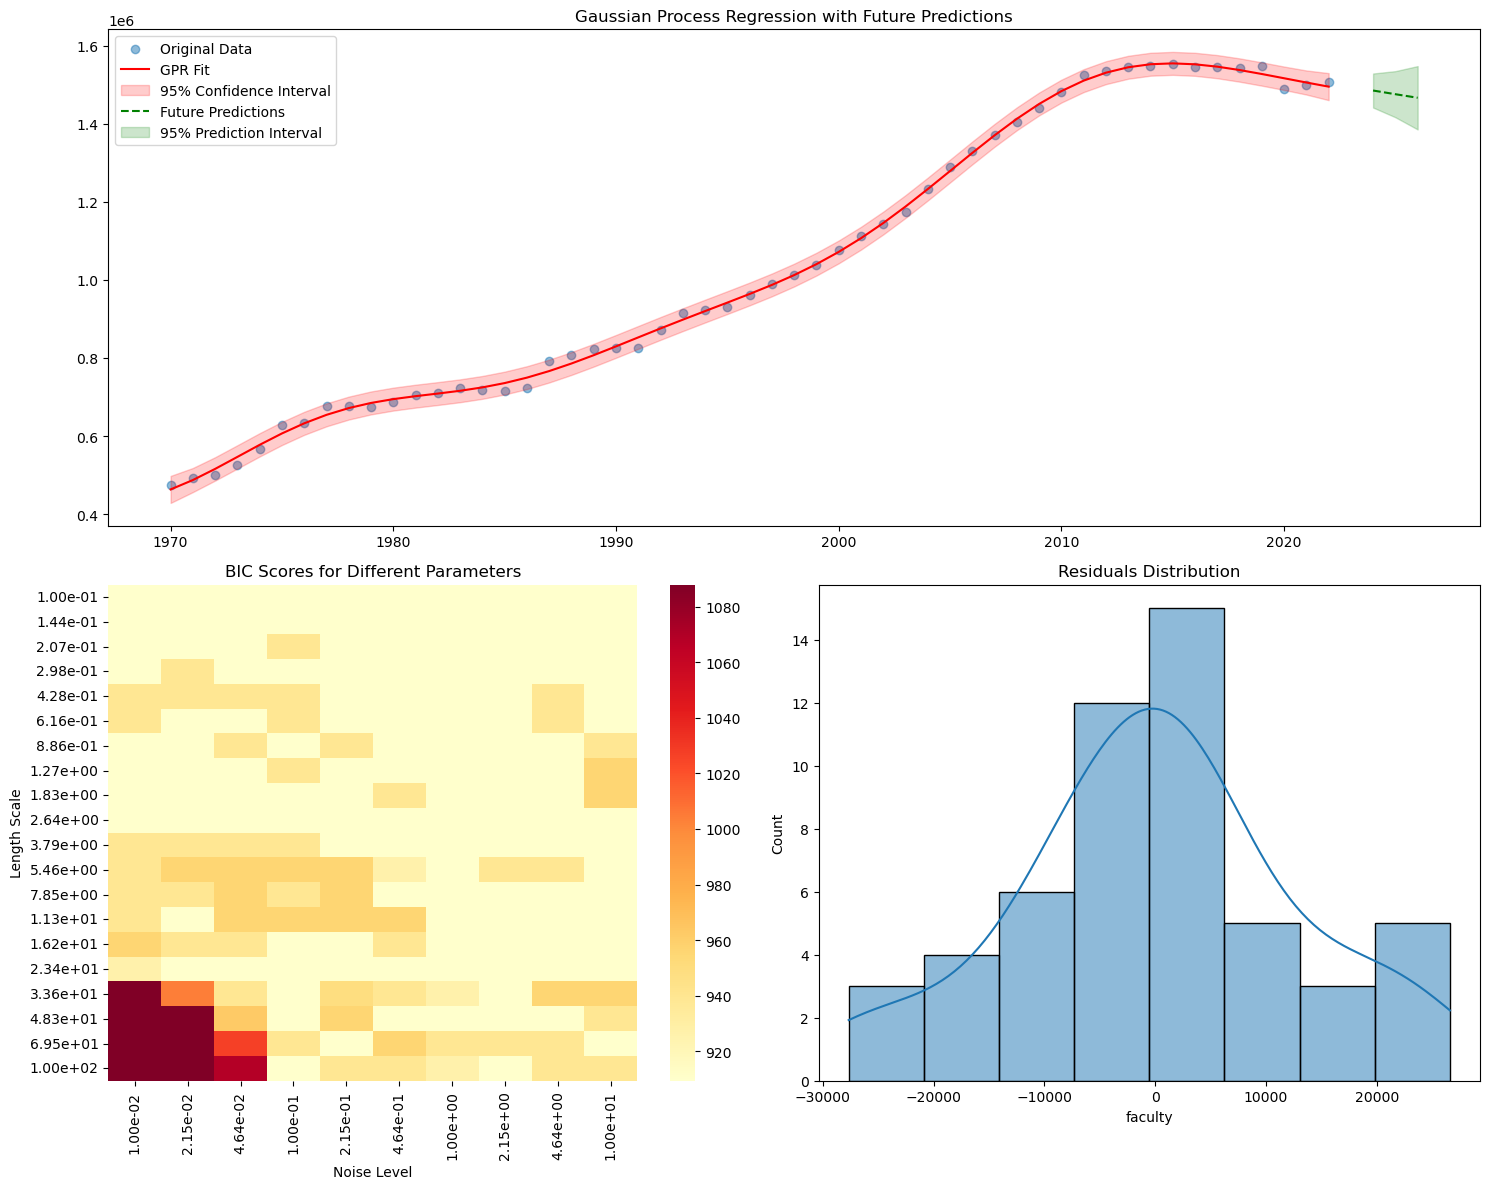

In [17]:
def perform_gpr_analysis_v2(y, kernel_type='RBF', k_fold=5):
    """
    Improved GPR analysis with proper scalar handling and broadcasting
    """
    # Convert input to numpy and get proper scalar values
    y_np = np.asarray(y.values, dtype=np.float64)
    x_np = np.arange(len(y_np), dtype=np.float64).reshape(-1, 1)
    
    # Get scalar values (guaranteed Python floats)
    x_mean = float(np.mean(x_np))
    x_std = float(np.std(x_np))
    y_mean = float(np.mean(y_np))
    y_std = float(np.std(y_np))
    
    # Scale inputs (will be numpy arrays)
    x_scaled = (x_np - x_mean) / x_std
    y_scaled = (y_np - y_mean) / y_std
    
    if kernel_type == 'RBF':
        length_scales = np.logspace(-1, 2, 20)
        noise_levels = np.logspace(-2, 1, 10)
        
        best_bic = float('inf')
        best_params = None
        results = {}
        
        for length_scale in length_scales:
            for noise_level in noise_levels:
                kernel = C(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
                
                cv_scores = []
                bic_scores = []
                
                kf = KFold(n_splits=k_fold, shuffle=False)
                
                for train_idx, test_idx in kf.split(x_scaled):
                    X_train = x_scaled[train_idx]
                    X_test = x_scaled[test_idx]
                    y_train = y_scaled[train_idx]
                    y_test = y_scaled[test_idx]
                    
                    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42,
                                                 n_restarts_optimizer=5)
                    gpr.fit(X_train, y_train)
                    
                    y_pred = gpr.predict(X_test)
                    y_pred_orig = y_pred * y_std + y_mean
                    y_test_orig = y_test * y_std + y_mean
                    
                    mse = mean_squared_error(y_test_orig, y_pred_orig)
                    cv_scores.append(mse)
                    
                    n = len(y_train)
                    bic = n * np.log(mse) + 3 * np.log(n)
                    bic_scores.append(bic)
                
                results[(length_scale, noise_level)] = {
                    'cv_mse_mean': float(np.mean(cv_scores)),
                    'cv_mse_std': float(np.std(cv_scores)),
                    'bic_mean': float(np.mean(bic_scores)),
                    'bic_std': float(np.std(bic_scores))
                }
                
                if results[(length_scale, noise_level)]['bic_mean'] < best_bic:
                    best_bic = results[(length_scale, noise_level)]['bic_mean']
                    best_params = (length_scale, noise_level)
    
    best_kernel = C(1.0) * RBF(length_scale=best_params[0]) + WhiteKernel(noise_level=best_params[1])
    final_gpr = GaussianProcessRegressor(kernel=best_kernel, random_state=42,
                                       n_restarts_optimizer=5)
    final_gpr.fit(x_scaled, y_scaled)
    
    # Get fitted values for training data
    y_pred_scaled, y_std_scaled = final_gpr.predict(x_scaled, return_std=True)
    y_pred = y_pred_scaled * y_std + y_mean
    y_fitted_std = y_std_scaled * y_std
    
    # Make future predictions (2023-2025)
    # Create future x values
    last_x = x_np[-1, 0]
    future_x = np.array([last_x + 1, last_x + 2, last_x + 3]).reshape(-1, 1)
    future_x_scaled = (future_x - x_mean) / x_std
    
    # Get predictions
    future_pred_scaled, future_std_scaled = final_gpr.predict(future_x_scaled, return_std=True)
    
    # Convert back to original scale - handle each prediction separately
    future_predictions = np.array([p * y_std + y_mean for p in future_pred_scaled])
    future_stds = np.array([s * y_std for s in future_std_scaled])
    
    return {
        'best_params': best_params,
        'results': results,
        'fitted_values': y_pred,
        'fitted_std': y_fitted_std,
        'future_predictions': future_predictions,
        'future_std': future_stds,
        'model': final_gpr,
        'x_scaled': x_scaled,
        'future_x_scaled': future_x_scaled,
        'best_bic': float(best_bic)
    }

gpr_analysis_2 = perform_gpr_analysis_v2(lagged_df['faculty'])
plot_gpr_results(lagged_df['faculty'], gpr_analysis_2)


Dynamic Regression Analysis Results:
Best model parameters:
Number of PCA components: 2
Number of lags: 6

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                faculty   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     888.2
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           5.41e-31
Time:                        08:59:15   Log-Likelihood:                -412.18
No. Observations:                  37   AIC:                             844.4
Df Residuals:                      27   BIC:                             860.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

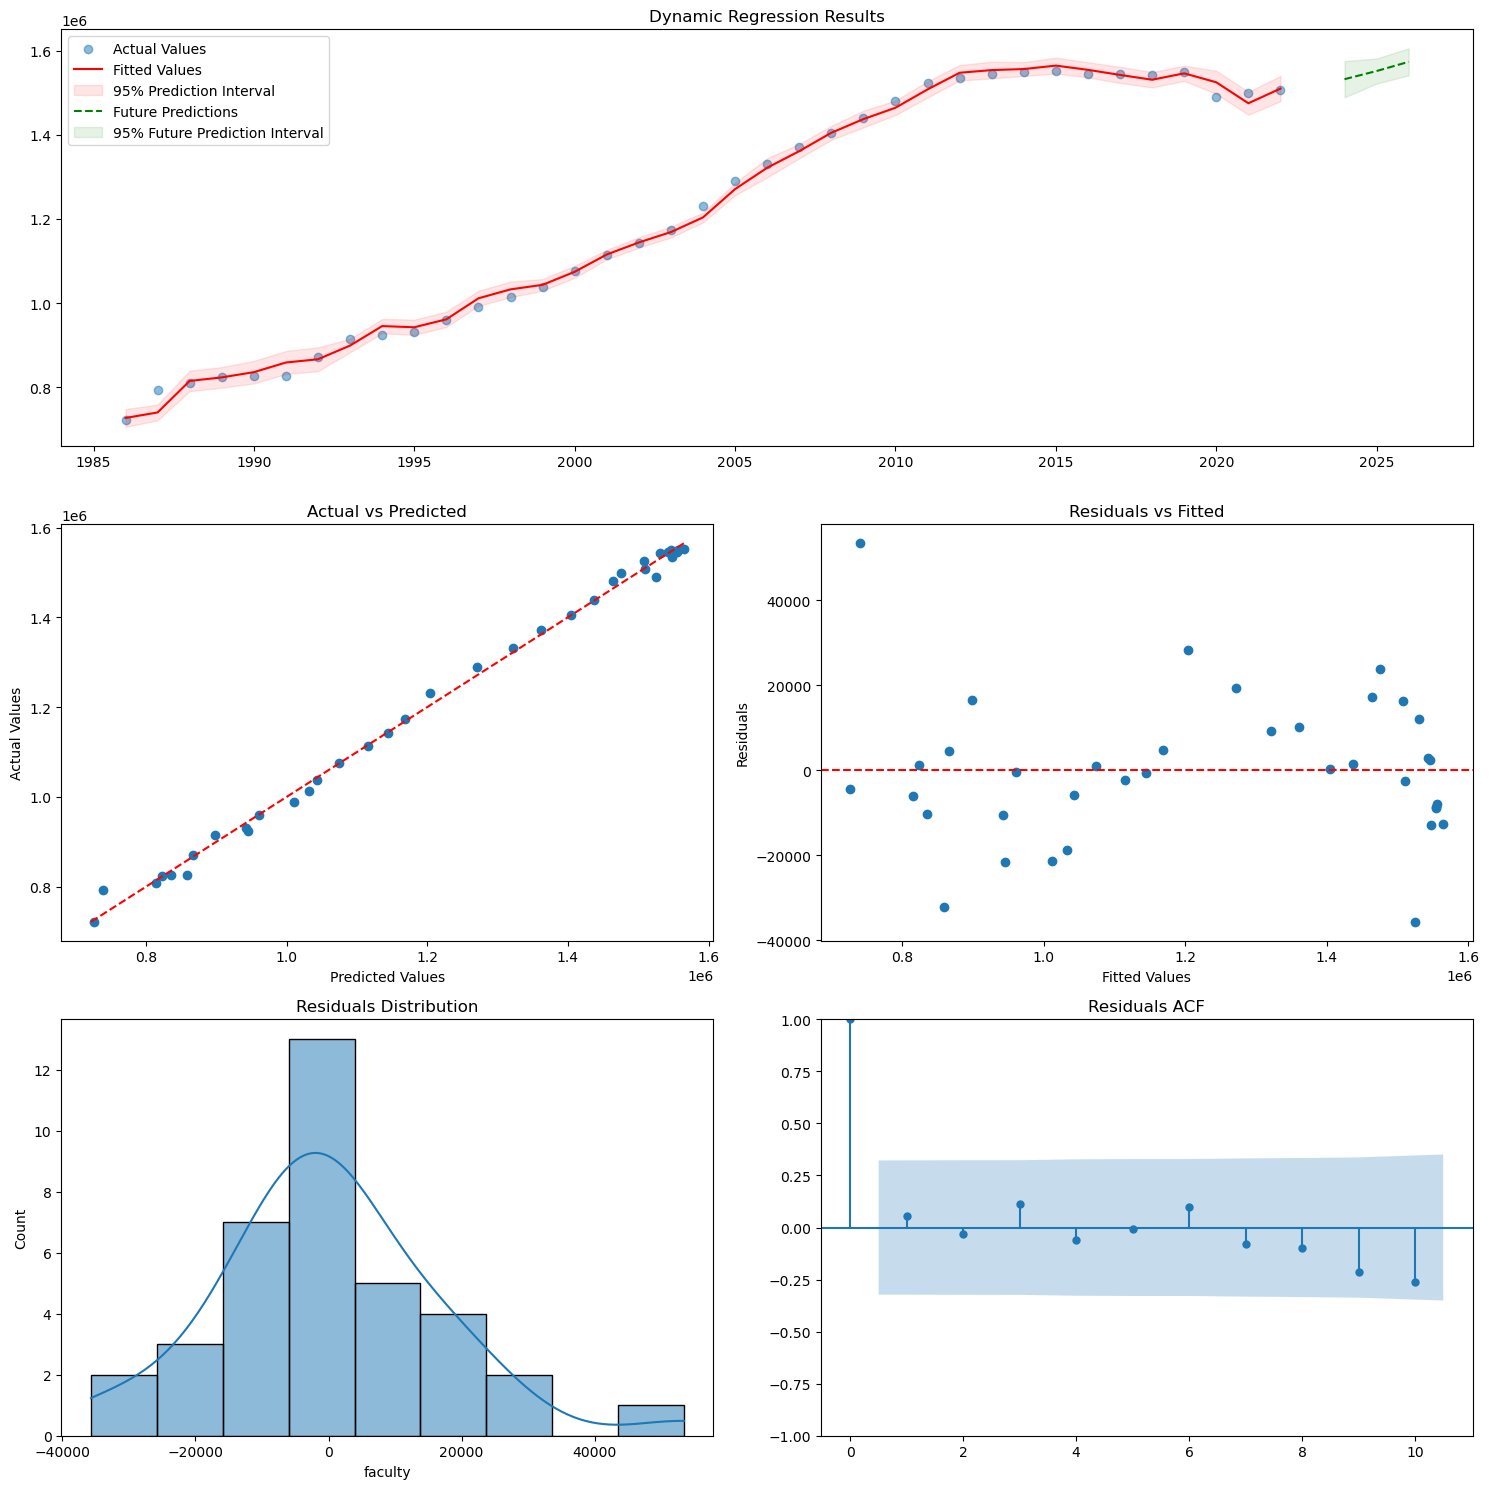


Optimal combination:
Number of components: 2
Number of lags: 6
BIC value: 860.48


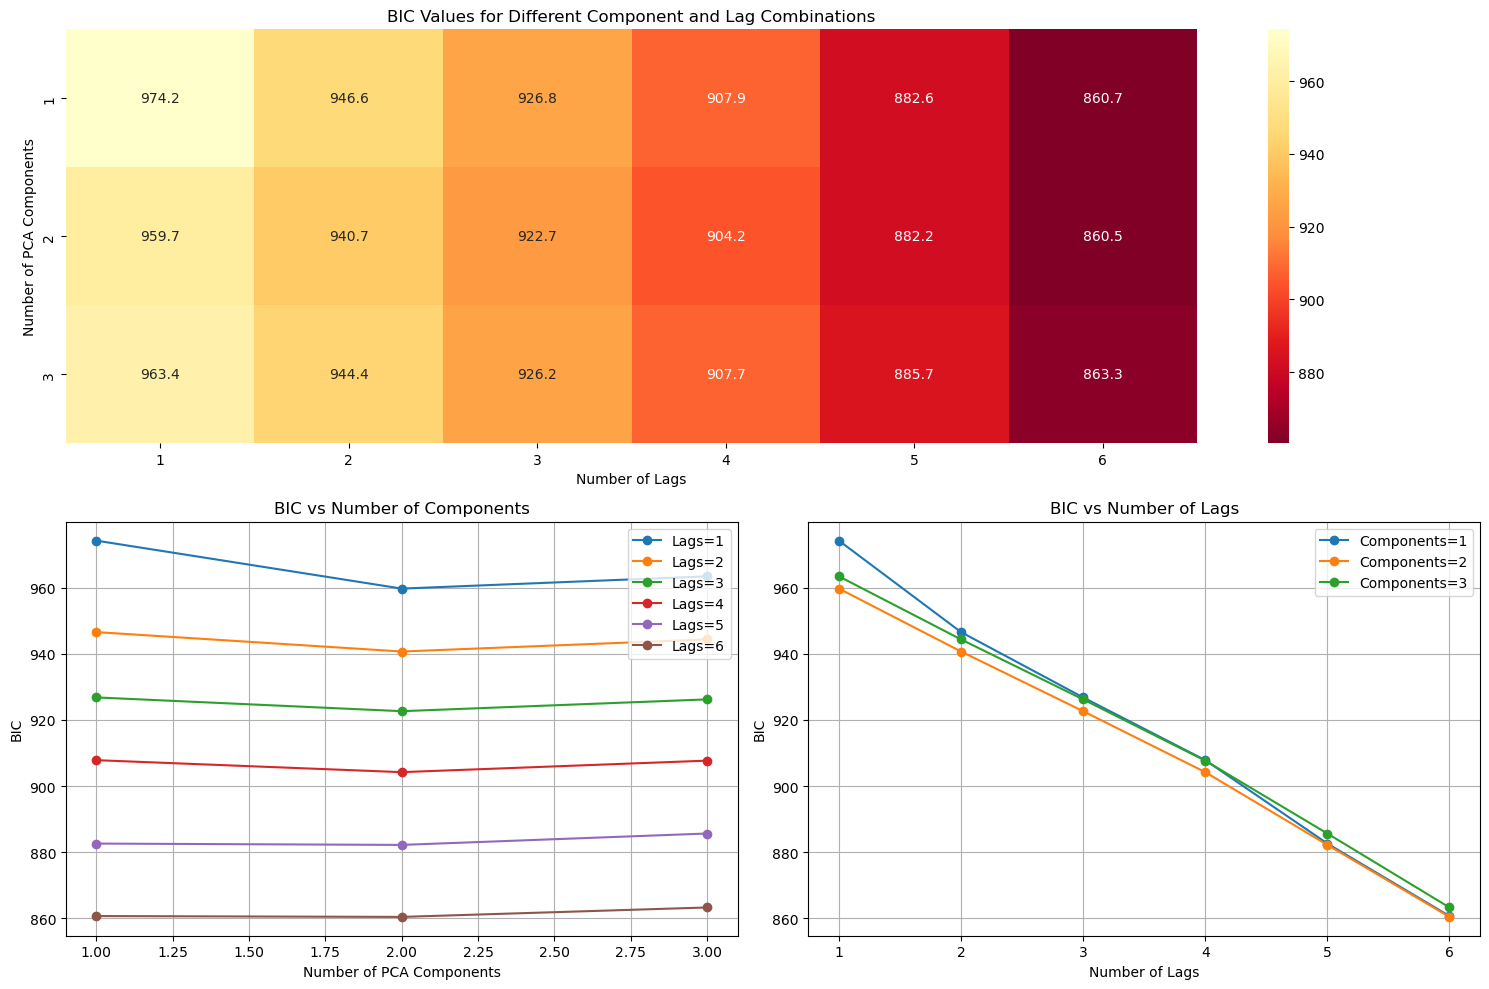

In [10]:
def perform_dynamic_regression(pca_results, target_series, max_components=None, max_lags=10):
    """
    Perform dynamic regression using PCA components and lagged values.
    """
    X = pca_results['pca_results']
    y = target_series
    
    # Ensure common index
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]
    
    # Create trend term
    trend = np.arange(len(y))
    
    if max_components is None:
        max_components = X.shape[1]
    
    best_bic = np.inf
    best_model = None
    best_params = None
    results = {}
    
    # Try different combinations of components and lags
    for n_components in range(1, min(max_components + 1, X.shape[1] + 1)):
        for n_lags in range(1, max_lags + 1):
            # Create lagged variables
            lagged_y = pd.DataFrame()
            for lag in range(1, n_lags + 1):
                lagged_y[f'lag_{lag}'] = y.shift(lag)
            
            # Combine predictors
            X_combined = pd.concat([
                pd.Series(trend, index=y.index, name='trend'),
                X.iloc[:, :n_components],
                lagged_y
            ], axis=1)
            
            # Drop rows with NaN from lagged variables
            mask = X_combined.notna().all(axis=1)
            X_model = X_combined[mask]
            y_model = y[mask]
            
            # Fit model
            model = sm.OLS(y_model, sm.add_constant(X_model))
            fitted_model = model.fit()
            
            # Calculate BIC
            bic = fitted_model.bic
            
            results[(n_components, n_lags)] = {
                'model': fitted_model,
                'bic': bic,
                'X': X_model,
                'y': y_model
            }
            
            if bic < best_bic:
                best_bic = bic
                best_model = fitted_model
                best_params = (n_components, n_lags)
    
    # Get predictions and prediction intervals for best model
    best_X = results[best_params]['X']
    X_with_const = sm.add_constant(best_X)
    predictions = best_model.get_prediction(X_with_const)
    fitted_values = predictions.predicted_mean
    prediction_se = predictions.se
    residuals = results[best_params]['y'] - fitted_values
    
    # Calculate prediction intervals
    conf_intervals = np.column_stack([
        fitted_values - 1.96 * prediction_se,
        fitted_values + 1.96 * prediction_se
    ])
    
    # Make future predictions (2023-2025)
    future_predictions = []
    future_se = []
    future_dates = pd.date_range(
        start=y.index[-1] + pd.DateOffset(years=1),
        periods=3,
        freq='Y'
    )
    
    # Get column names and their order from the best model
    n_components = best_params[0]
    n_lags = best_params[1]
    
    # For future predictions, we need to:
    # 1. Extend the trend
    # 2. Use the last n_components PCA scores
    # 3. Use the last known values for lags
    for i in range(3):  # 3 years ahead
        future_row = pd.DataFrame(index=[0])
        
        # Add trend
        future_row['trend'] = trend[-1] + i + 1
        
        # Add PCA components
        for j in range(n_components):
            future_row[f'PC{j+1}'] = X.iloc[-1, j]
        
        # Add lagged values
        for lag in range(1, n_lags + 1):
            if i == 0:
                lagged_value = y.iloc[-(lag)]
            else:
                lagged_value = future_predictions[i-1]
            future_row[f'lag_{lag}'] = lagged_value
        
        # First reorder columns to match training data
        future_row = future_row[best_X.columns]
        # Then add constant to match the model's expected input
        future_X = sm.add_constant(future_row, has_constant='add')  # Force adding constant
        
        # Get prediction and its standard error
        future_prediction = best_model.get_prediction(future_X)
        pred = future_prediction.predicted_mean[0]
        pred_se = future_prediction.se[0]
        
        future_predictions.append(pred)
        future_se.append(pred_se)
    
    future_intervals = np.column_stack([
        np.array(future_predictions) - 1.96 * np.array(future_se),
        np.array(future_predictions) + 1.96 * np.array(future_se)
    ])
    
    return {
        'best_model': best_model,
        'best_params': best_params,
        'results': results,
        'fitted_values': fitted_values,
        'residuals': residuals,
        'prediction_intervals': conf_intervals,
        'future_predictions': future_predictions,
        'future_dates': future_dates,
        'future_intervals': future_intervals,
        'X': best_X,
        'y': results[best_params]['y']
    }

def plot_bic_analysis(results):
    """
    Create a heatmap and line plots showing how BIC varies with number of 
    components and lags.
    
    Parameters:
    -----------
    results : dict
        The results dictionary from perform_dynamic_regression
    """
    # Extract BIC values and parameters
    bic_data = []
    for (n_comp, n_lag), result in results['results'].items():
        bic_data.append({
            'Components': n_comp,
            'Lags': n_lag,
            'BIC': result['bic']
        })
    
    # Convert to DataFrame
    bic_df = pd.DataFrame(bic_data)
    
    # Create pivot table for heatmap
    bic_pivot = bic_df.pivot(index='Components', 
                            columns='Lags', 
                            values='BIC')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # Heatmap
    ax1 = fig.add_subplot(gs[0, :])
    sns.heatmap(bic_pivot, 
                annot=True, 
                fmt='.1f', 
                cmap='YlOrRd_r',
                ax=ax1)
    ax1.set_title('BIC Values for Different Component and Lag Combinations')
    ax1.set_xlabel('Number of Lags')
    ax1.set_ylabel('Number of PCA Components')
    
    # Line plot by components
    ax2 = fig.add_subplot(gs[1, 0])
    for lag in bic_df['Lags'].unique():
        lag_data = bic_df[bic_df['Lags'] == lag]
        ax2.plot(lag_data['Components'], 
                lag_data['BIC'], 
                'o-', 
                label=f'Lags={lag}')
    ax2.set_xlabel('Number of PCA Components')
    ax2.set_ylabel('BIC')
    ax2.set_title('BIC vs Number of Components')
    ax2.legend()
    ax2.grid(True)
    
    # Line plot by lags
    ax3 = fig.add_subplot(gs[1, 1])
    for comp in bic_df['Components'].unique():
        comp_data = bic_df[bic_df['Components'] == comp]
        ax3.plot(comp_data['Lags'], 
                comp_data['BIC'], 
                'o-', 
                label=f'Components={comp}')
    ax3.set_xlabel('Number of Lags')
    ax3.set_ylabel('BIC')
    ax3.set_title('BIC vs Number of Lags')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    
    # Print optimal combination
    best_combo = bic_df.loc[bic_df['BIC'].idxmin()]
    print(f"\nOptimal combination:")
    print(f"Number of components: {int(best_combo['Components'])}")
    print(f"Number of lags: {int(best_combo['Lags'])}")
    print(f"BIC value: {best_combo['BIC']:.2f}")
    
    plt.show()

def plot_dynamic_regression_results(analysis_results):
    """Plot comprehensive results from dynamic regression analysis"""
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(3, 2)
    
    # Plot 1: Time series with forecasts
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot original data and fitted values
    ax1.scatter(analysis_results['y'].index, 
                analysis_results['y'], 
                alpha=0.5, 
                label='Actual Values')
    
    ax1.plot(analysis_results['y'].index,
             analysis_results['fitted_values'],
             'r-',
             label='Fitted Values')
    
    # Add prediction intervals
    ax1.fill_between(analysis_results['y'].index,
                     analysis_results['prediction_intervals'][:, 0],
                     analysis_results['prediction_intervals'][:, 1],
                     color='r',
                     alpha=0.1,
                     label='95% Prediction Interval')
    
    # Plot future predictions
    ax1.plot(analysis_results['future_dates'],
             analysis_results['future_predictions'],
             'g--',
             label='Future Predictions')
    
    # Add future prediction intervals
    ax1.fill_between(analysis_results['future_dates'],
                     analysis_results['future_intervals'][:, 0],
                     analysis_results['future_intervals'][:, 1],
                     color='g',
                     alpha=0.1,
                     label='95% Future Prediction Interval')
    
    ax1.set_title('Dynamic Regression Results')
    ax1.legend()
    
    # Plot 2: Actual vs Predicted
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(analysis_results['fitted_values'],
                analysis_results['y'])
    
    min_val = min(analysis_results['fitted_values'].min(),
                  analysis_results['y'].min())
    max_val = max(analysis_results['fitted_values'].max(),
                  analysis_results['y'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Actual Values')
    ax2.set_title('Actual vs Predicted')
    
    # Plot 3: Residuals vs Fitted
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(analysis_results['fitted_values'],
                analysis_results['residuals'])
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_xlabel('Fitted Values')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Residuals vs Fitted')
    
    # Plot 4: Residuals Distribution
    ax4 = fig.add_subplot(gs[2, 0])
    sns.histplot(analysis_results['residuals'],
                kde=True,
                ax=ax4)
    ax4.set_title('Residuals Distribution')
    
    # Plot 5: Residuals ACF
    ax5 = fig.add_subplot(gs[2, 1])
    sm.graphics.tsa.plot_acf(analysis_results['residuals'],
                            lags=10,
                            ax=ax5)
    ax5.set_title('Residuals ACF')
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nDynamic Regression Analysis Results:")
    print("================================")
    print(f"Best model parameters:")
    print(f"Number of PCA components: {analysis_results['best_params'][0]}")
    print(f"Number of lags: {analysis_results['best_params'][1]}")
    
    print("\nModel Summary:")
    print(analysis_results['best_model'].summary())
    
    print("\nFuture Predictions (2023-2025):")
    for date, pred, (lower, upper) in zip(analysis_results['future_dates'],
                                        analysis_results['future_predictions'],
                                        analysis_results['future_intervals']):
        print(f"{date.year}: {pred:.2f} (95% CI: [{lower:.2f}, {upper:.2f}])")
    
    plt.show()

def plot_bic_analysis(results):
    """
    Create a heatmap and line plots showing how BIC varies with number of 
    components and lags.
    
    Parameters:
    -----------
    results : dict
        The results dictionary from perform_dynamic_regression
    """
    # Extract BIC values and parameters
    bic_data = []
    for (n_comp, n_lag), result in results['results'].items():
        bic_data.append({
            'Components': n_comp,
            'Lags': n_lag,
            'BIC': result['bic']
        })
    
    # Convert to DataFrame
    bic_df = pd.DataFrame(bic_data)
    
    # Create pivot table for heatmap
    bic_pivot = bic_df.pivot(index='Components', 
                            columns='Lags', 
                            values='BIC')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # Heatmap
    ax1 = fig.add_subplot(gs[0, :])
    sns.heatmap(bic_pivot, 
                annot=True, 
                fmt='.1f', 
                cmap='YlOrRd_r',
                ax=ax1)
    ax1.set_title('BIC Values for Different Component and Lag Combinations')
    ax1.set_xlabel('Number of Lags')
    ax1.set_ylabel('Number of PCA Components')
    
    # Line plot by components
    ax2 = fig.add_subplot(gs[1, 0])
    for lag in bic_df['Lags'].unique():
        lag_data = bic_df[bic_df['Lags'] == lag]
        ax2.plot(lag_data['Components'], 
                lag_data['BIC'], 
                'o-', 
                label=f'Lags={lag}')
    ax2.set_xlabel('Number of PCA Components')
    ax2.set_ylabel('BIC')
    ax2.set_title('BIC vs Number of Components')
    ax2.legend()
    ax2.grid(True)
    
    # Line plot by lags
    ax3 = fig.add_subplot(gs[1, 1])
    for comp in bic_df['Components'].unique():
        comp_data = bic_df[bic_df['Components'] == comp]
        ax3.plot(comp_data['Lags'], 
                comp_data['BIC'], 
                'o-', 
                label=f'Components={comp}')
    ax3.set_xlabel('Number of Lags')
    ax3.set_ylabel('BIC')
    ax3.set_title('BIC vs Number of Lags')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    
    # Print optimal combination
    best_combo = bic_df.loc[bic_df['BIC'].idxmin()]
    print(f"\nOptimal combination:")
    print(f"Number of components: {int(best_combo['Components'])}")
    print(f"Number of lags: {int(best_combo['Lags'])}")
    print(f"BIC value: {best_combo['BIC']:.2f}")
    
    plt.show()


    
dynamic_results = perform_dynamic_regression(pca_results, lagged_df['faculty'], max_components=3, max_lags=6)
plot_dynamic_regression_results(dynamic_results)
plot_bic_analysis(dynamic_results)